In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from copy import deepcopy
import numpy as np


In [58]:

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight_mu, gain=nn.init.calculate_gain('relu'))
        nn.init.uniform_(self.weight_rho, -4, -3)

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features))
        nn.init.zeros_(self.bias_mu)
        nn.init.uniform_(self.bias_rho, -5, -4)

    def forward(self, x, sample=True):
        if sample:
            weight_sigma = torch.log1p(torch.exp(self.weight_rho))
            weight = self.weight_mu + weight_sigma * torch.randn_like(weight_sigma)
            bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            bias = self.bias_mu + bias_sigma * torch.randn_like(bias_sigma)
        else:
            weight, bias = self.weight_mu, self.bias_mu
        return F.linear(x, weight, bias)

    def kl_loss(self):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        kl = -0.5 * torch.sum(1 + 2 * torch.log(weight_sigma) - self.weight_mu.pow(2) - weight_sigma.pow(2))
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        kl += -0.5 * torch.sum(1 + 2 * torch.log(bias_sigma) - self.bias_mu.pow(2) - bias_sigma.pow(2))
        return kl

In [59]:

class BNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_rate):
        super().__init__()
        self.blocks = nn.ModuleList()
        self.device = torch.device('cpu')
        prev_dim = input_dim

        # Improve the residual connection structure
        for h_dim in hidden_dims:
            main_path = nn.ModuleList([
                BayesianLinear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ELU(),
                nn.Dropout(dropout_rate),
                BayesianLinear(h_dim, h_dim),
                nn.BatchNorm1d(h_dim)
            ])
            self.blocks.append(main_path)

            # Strengthen the jump connection structure
            if prev_dim != h_dim:
                skip_conn = nn.Sequential(
                    BayesianLinear(prev_dim, h_dim),
                    nn.BatchNorm1d(h_dim),
                    nn.ELU()
                )
            else:
                skip_conn = nn.Identity()
            self.blocks.append(skip_conn)

            prev_dim = h_dim
        self.out_layer = BayesianLinear(prev_dim, output_dim)

    def forward(self, x, sample=True):
        for i in range(0, len(self.blocks), 2):
            main_path = self.blocks[i]
            skip_conn = self.blocks[i + 1]

            residual = skip_conn(x) if isinstance(skip_conn, nn.Sequential) else skip_conn(x)

            x = main_path[0](x, sample)
            x = main_path[1](x)
            x = main_path[2](x)
            x = main_path[3](x)
            x = main_path[4](x, sample)
            x = main_path[5](x)

            assert x.shape == residual.shape, f"Dimension mismatch: {x.shape} vs {residual.shape}"
            x = x + residual
        return self.out_layer(x, sample)

    def kl_loss(self):
        total_kl = 0
        for i in range(0, len(self.blocks), 2):
            main_path = self.blocks[i]
            total_kl += main_path[0].kl_loss() + main_path[4].kl_loss()
        return total_kl + self.out_layer.kl_loss()

In [60]:

def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path, header=None, skiprows=1)
    test_df = pd.read_csv(test_path, header=None, skiprows=1)

    X_train = train_df.iloc[:, :-1].values.astype('float32')
    y_train = train_df.iloc[:, -1].values.astype('int64') - 1
    X_test = test_df.iloc[:, :-1].values.astype('float32')
    y_test = test_df.iloc[:, -1].values.astype('int64') - 1

    print("\ndata distribution:")
    print(f"The number of training set samples: {len(X_train)} | class distribution: {np.bincount(y_train)}")
    print(f"The number of test set samples: {len(X_test)} | class distribution: {np.bincount(y_test)}")

    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    return (
        DataLoader(train_dataset, batch_size=32, shuffle=True),
        torch.tensor(X_test),
        torch.tensor(y_test)
    )

In [61]:

def focal_loss(outputs, targets, class_weights, gamma=3):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    weights = class_weights.to(outputs.device)[targets]
    return (weights * (1 - pt) ** gamma * ce_loss).mean()

from torch.utils.data import DataLoader, TensorDataset, Subset


In [62]:

def train_reptile(model, train_loader, params, X_test, y_test):
    # Initializer meta optimizer and learning rate scheduler
    meta_optimizer = torch.optim.AdamW(model.parameters(), lr=params['meta_lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(meta_optimizer, T_max=params['num_epochs'])
    total_losses = []
    cls_losses = []      # Classification loss component
    kl_losses = []       # KL divergence loss component
    # Dynamic category weights (based on training set statistics)
    class_counts = np.bincount(train_loader.dataset.tensors[1].numpy())
    class_weights = 1.0 / (class_counts + 1e-6)
    class_weights = torch.tensor(class_weights / class_weights.sum(), dtype=torch.float32).to(model.device)

    # Training monitoring parameters
    best_f1, patience = 0, 0
    grad_history = []

    for epoch in range(params['num_epochs']):
        kl_weight = params['kl_weight'] * (0.5 * (1 + np.cos(np.pi * epoch / params['num_epochs'])))
        all_indices = np.arange(len(train_loader.dataset))
        np.random.shuffle(all_indices)
        '''
        task_size = len(train_loader.dataset) // 5  # Randomly divide into five tasks
        task_indices = [all_indices[i * task_size:(i + 1) * task_size] for i in range(5)]
        '''
        task_size = 64  # Each task has a fixed 64 samples
        task_indices = [np.random.choice(len(train_loader.dataset), task_size)
                        for _ in range(5)]
        task_loaders = [
            DataLoader(
                Subset(train_loader.dataset, indices),
                batch_size=32,
                shuffle=True,
                drop_last=True
            ) for indices in task_indices
        ]

        meta_optimizer.zero_grad()
        epoch_loss = 0
        epoch_cls = 0     # 分类损失
        epoch_kl = 0      # KL损失
        for task_idx, task_loader in enumerate(task_loaders):
            # Create a temporary copy of the model
            temp_model = deepcopy(model).to(model.device)
            inner_optim = torch.optim.SGD(
                temp_model.parameters(),
                lr=params['inner_lr'],
                momentum=0.95,
                nesterov=True
            )

            for _ in range(params['num_inner_steps']):
                for X_batch, y_batch in task_loader:
                    X_batch, y_batch = X_batch.to(model.device), y_batch.to(model.device)

                    # forward propagation
                    outputs = temp_model(X_batch)

                    cls_loss = focal_loss(outputs, y_batch, class_weights)
                    kl_loss = temp_model.kl_loss()
                    loss = cls_loss + kl_weight * kl_loss
                    # back propagation
                    inner_optim.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(temp_model.parameters(), max_norm=1.0)
                    inner_optim.step()
                    epoch_cls += cls_loss.item()
                    epoch_kl += kl_weight * kl_loss.item()
                    epoch_loss += loss.item()

            # Meta-gradient accumulation
            with torch.no_grad():
                for p_model, p_temp in zip(model.parameters(), temp_model.parameters()):
                    if p_model.grad is None:
                        p_model.grad = torch.zeros_like(p_model.data)
                    p_model.grad.add_((p_model.data - p_temp.data) * 0.5 / len(task_loaders))

            del temp_model

        meta_optimizer.step()
        scheduler.step()
        num_tasks = len(task_loaders)
        total_losses.append(epoch_loss / num_tasks)
        cls_losses.append(epoch_cls / num_tasks)
        kl_losses.append(epoch_kl / num_tasks)
        if (epoch + 1) % 2 == 0:
            with torch.no_grad():
                # Parameter distribution monitoring
                weight_sigma = torch.log1p(torch.exp(model.blocks[0][0].weight_rho))
                print(f"\n=== Epoch {epoch + 1}/{params['num_epochs']} ===")
                print(f"[Param] Weighted variance range: {weight_sigma.min():.3f}~{weight_sigma.max():.3f}")

                # Gradient dynamic monitoring
                grad_norms = [p.grad.norm().item() for p in model.parameters() if p.grad is not None]
                grad_history.append(np.mean(grad_norms))
                print(f"[Grad] mean value: {np.mean(grad_norms):.3e} | Max: {np.max(grad_norms):.3e}")

                # Loss component monitoring
                sample_outputs = model(X_test[:32].to(model.device))
                kl = model.kl_loss().item()
                cls_loss = F.cross_entropy(sample_outputs, y_test[:32].to(model.device)).item()
                print(f"[Loss] KL: {kl:.3f} | class: {cls_loss:.3f} | overall loss: {epoch_loss:.3f}")

        if (epoch + 1) % 5 == 0:
            metrics = evaluate(model, X_test.to(model.device), y_test.to(model.device))

            # Early stop logic
            if metrics['f1'] > best_f1:
                best_f1 = metrics['f1']
                torch.save(model.state_dict(), f'best_model_epoch{epoch + 1}.pth')
                patience = 0
            else:
                patience += 1
                if patience >= 10: #Originally it was 5
                    print(f"! Early stop is triggered at epoch {epoch + 1}，Best F1: {best_f1:.4f}")
                    return model, (total_losses, cls_losses, kl_losses)

            print(
                f"[Eval] F1: {metrics['f1']:.4f} | Acc: {metrics['accuracy']:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

    return model, (total_losses, cls_losses, kl_losses)


In [63]:

def evaluate(model, X_test, y_test, num_samples=300):
    model.eval()
    logits = []
    with torch.no_grad():
        for _ in range(num_samples):
            outputs = model(X_test, sample=True)
            smoothed_outputs = (1 - 0.2) * outputs + 0.2 / outputs.shape[1]  # 调整标签平滑参数
            logits.append(smoothed_outputs)

    logits = torch.stack(logits).mean(0)
    temperature = nn.Parameter(torch.ones(1, device=logits.device))
    optimizer = torch.optim.LBFGS([temperature], lr=0.01, max_iter=500)  # 增加迭代次数

    def eval_loss():
        optimizer.zero_grad()
        loss = F.cross_entropy(logits / temperature, y_test)
        loss.backward()
        return loss

    for _ in range(100): optimizer.step(eval_loss)

    calib_probs = F.softmax(logits / temperature, dim=1)
    preds = calib_probs.argmax(dim=1).cpu().numpy()


    return {
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds, average='macro', zero_division=0),
        'recall': recall_score(y_test, preds, average='macro', zero_division=0),
        'f1': f1_score(y_test, preds, average='macro', zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, preds)
    }


In [64]:

def parameter_search(train_loader, X_test, y_test, num_trials=30):
    param_space = {
        'meta_lr': [3e-4, 5e-4, 1e-3],
        'inner_lr': [0.05, 0.1, 0.15],
        'num_inner_steps': [7, 10, 15],
        'kl_weight': [0.001, 0.003, 0.005],
        'hidden_dims': [
            [512, 256, 128],
            [256, 128, 64, 32],
            [512, 512, 256, 128],
            [1024, 512]
        ],
        'dropout_rate': [0.2, 0.35, 0.5],
        'num_epochs': [100],
        'eval_samples': [60]
    }

    best_score = 0
    best_params = None
    results = []

    for trial in range(num_trials):
        params = {k: random.choice(v) for k, v in param_space.items()}
        params['hidden_dims'] = random.choice(param_space['hidden_dims'])

        print(f"\ntrial {trial + 1}/{num_trials}")
        print(f"Parameter Combination: { {k: v for k, v in params.items() if k != 'hidden_dims'} }")
        print(f"Network structure: {params['hidden_dims']}")

        model = BNN(21, 4, params['hidden_dims'], params['dropout_rate'])
        trained_model, trial_losses = train_reptile(model, train_loader, params, X_test, y_test)

        metrics = evaluate(trained_model, X_test, y_test, params['eval_samples'])
        results.append((params, metrics, trial_losses))

        if metrics['f1'] > best_score:
            best_score = metrics['f1']
            best_params = params
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Current F1: {metrics['f1']:.4f} | Best F1: {best_score:.4f}")

    #pd.DataFrame([{**p, **m} for p, m in results]).to_csv('search_results.csv', index=False)
    return best_params


In [65]:


train_loader, X_test, y_test = load_data('train_smote_pca.csv', 'test_smote_pca.csv')

# parameter search
print("\nStart parameter search...")
best_params = parameter_search(train_loader, X_test, y_test)

    # Final train
print("\nConduct the final training using the best parameters...")
final_model = BNN(
        input_dim=21,
        output_dim=4,
        hidden_dims=best_params['hidden_dims'],
        dropout_rate=best_params['dropout_rate']
    )
final_params = {
        **best_params,
        'num_epochs': 150,
        'kl_weight': best_params['kl_weight'] * 0.6
    }
final_model, (final_losses, cls_losses, kl_losses) = train_reptile(final_model, train_loader, final_params, X_test, y_test)

final_metrics = evaluate(final_model, X_test, y_test, num_samples=300)
print("\nFinal Performance:")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"F1: {final_metrics['f1']:.4f}")
print("confusion_matrix:\n", final_metrics['confusion_matrix'])


data distribution:
The number of training set samples: 600 | class distribution: [150 150 150 150]
The number of test set samples: 86 | class distribution: [37  6 38  5]

Start parameter search...

trial 1/30
Parameter Combination: {'meta_lr': 0.0005, 'inner_lr': 0.1, 'num_inner_steps': 7, 'kl_weight': 0.001, 'dropout_rate': 0.5, 'num_epochs': 100, 'eval_samples': 60}
Network structure: [1024, 512]

=== Epoch 2/100 ===
[Param] Weighted variance range: 0.018~0.049
[Grad] mean value: 1.536e-01 | Max: 1.673e+00
[Loss] KL: 5618671.500 | class: 2.435 | overall loss: 393151.697

=== Epoch 4/100 ===
[Param] Weighted variance range: 0.018~0.049
[Grad] mean value: 1.612e-01 | Max: 1.921e+00
[Loss] KL: 5616816.500 | class: 1.812 | overall loss: 392214.599
[Eval] F1: 0.5196 | Acc: 0.7674 | LR: 4.97e-04

=== Epoch 6/100 ===
[Param] Weighted variance range: 0.018~0.049
[Grad] mean value: 1.715e-01 | Max: 2.123e+00
[Loss] KL: 5614950.000 | class: 2.406 | overall loss: 390519.448

=== Epoch 8/100 ==

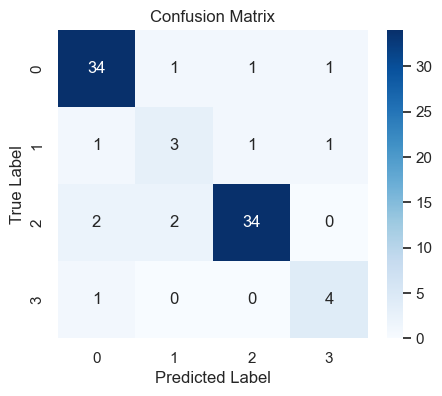

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = final_metrics['confusion_matrix']

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

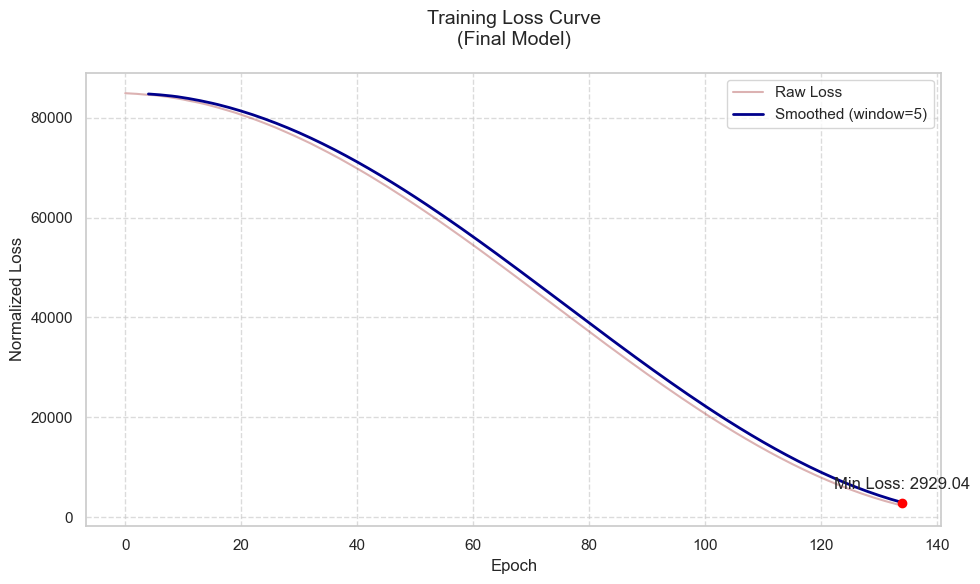

In [67]:

plt.figure(figsize=(10, 6))
window_size = 5
smoothed_losses = np.convolve(final_losses, np.ones(window_size) / window_size, mode='valid')
plt.plot(final_losses, alpha=0.3, label='Raw Loss', color='darkred')
plt.plot(range(window_size - 1, len(final_losses)), smoothed_losses,
             linewidth=2, label=f'Smoothed (window={window_size})', color='darkblue')

plt.title('Training Loss Curve\n(Final Model)', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Normalized Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

    # Mark the best epoch
best_epoch = np.argmin(smoothed_losses)
plt.scatter(best_epoch + window_size - 1, smoothed_losses[best_epoch],
                color='red', zorder=5, label=f'Best Epoch: {best_epoch + window_size}')
plt.annotate(f'Min Loss: {smoothed_losses[best_epoch]:.2f}',
                 (best_epoch + window_size - 1, smoothed_losses[best_epoch]),
                 textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.savefig('training_loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

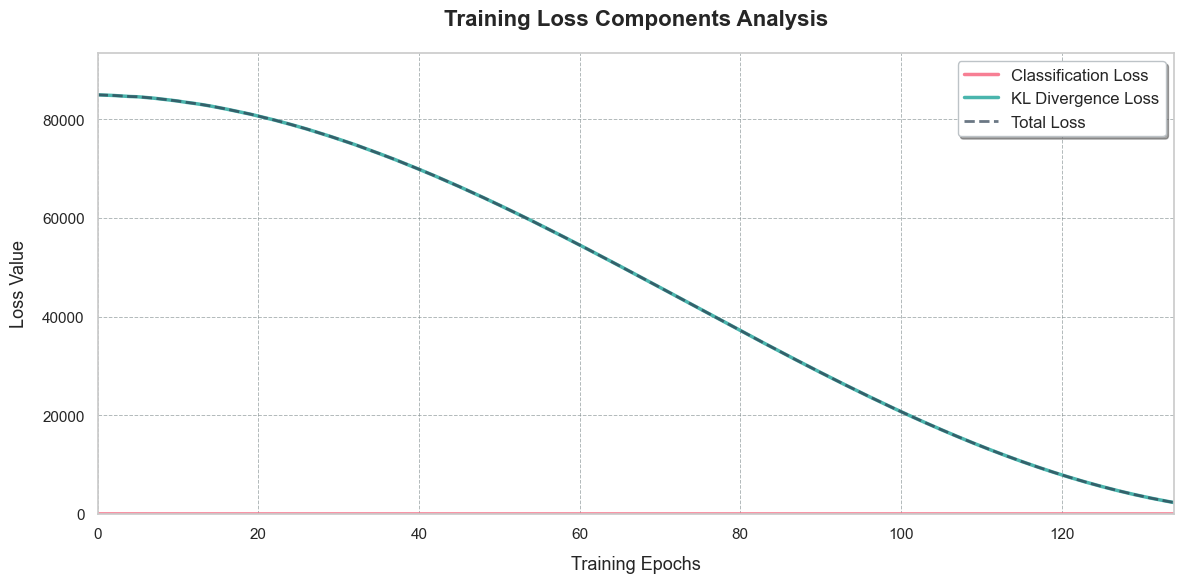

In [68]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
palette = sns.color_palette("husl", 2)

cls_line, = plt.plot(cls_losses,
                   color=palette[0],
                   linewidth=2.5,
                   alpha=0.9,
                   label='Classification Loss')

kl_line, = plt.plot(kl_losses,
                   color=palette[1],
                   linewidth=2.5,
                   alpha=0.9,
                   label='KL Divergence Loss')

total_line, = plt.plot(final_losses,
                      '--',
                      color='#2c3e50',
                      linewidth=2,
                      alpha=0.7,
                      label='Total Loss')

# 图表装饰
plt.title('Training Loss Components Analysis',
         fontsize=16,
         pad=20,
         fontweight='bold')

plt.xlabel('Training Epochs',
          fontsize=13,
          labelpad=10)

plt.ylabel('Loss Value',
           fontsize=13,
           labelpad=10)

# 高级图例配置
legend = plt.legend(
    handles=[cls_line, kl_line, total_line],
    frameon=True,
    loc='upper right',
    shadow=True,
    prop={'size': 12},
    facecolor='white',
    edgecolor='#bdc3c7'
)

# 网格线增强
plt.grid(True,
        linestyle='--',
        linewidth=0.7,
        alpha=0.6,
        color='#7f8c8d')

# 坐标轴范围优化
plt.xlim(left=0, right=len(cls_losses)-1)
plt.ylim(bottom=0, top=max(max(cls_losses), max(kl_losses), max(final_losses)) * 1.1)

# 添加双精度刻度
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# 保存高分辨率图片
plt.savefig('loss_components_analysis.png',
           dpi=300,
           bbox_inches='tight',
           transparent=False)

plt.tight_layout()
plt.show()


